## Forced turbulence with the Kolmogorov energy cascade

- Finite volume method on a MAC grid.

In [1]:
import torch
from torch_cfd import grids, boundaries
from torch_cfd.initial_conditions import filtered_velocity_field

from torch_cfd.equations import stable_time_step
from torch_cfd.fvm import RKStepper, NavierStokes2DFVMProjection
from torch_cfd.forcings import KolmogorovForcing
import torch_cfd.finite_differences as fdm

from tqdm import tqdm

In [2]:
n = 256
batch_size = 16
density = 1.0
max_velocity = 3.0
peak_wavenumber = 4.0
cfl_safety_factor = 0.5
viscosity = 1e-3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)
inner_steps = 20
outer_steps = 100
diam = 2 * torch.pi

grid = grids.Grid((n, n), domain=((0, diam), (0, diam)), device=device)

In [3]:
v0 = filtered_velocity_field(
    grid, max_velocity, peak_wavenumber, iterations=3, random_state=42,
    device=device, batch_size=batch_size,)
print(f"Initial velocity field:\n{v0.shape} {v0.dtype} {v0.device}")
v0div = fdm.divergence(v0)
pressure_bc = boundaries.get_pressure_bc_from_velocity(v0)

print(f"divergence of initial velocity L2 in this batch: {v0div.L2norm.data}")

dt = stable_time_step(
    dx=min(grid.step),
    max_velocity=max_velocity,
    max_courant_number=cfl_safety_factor,
    viscosity=viscosity,
)
print(f"dt: {dt} | batch size: {batch_size} | grid: {grid.shape}")
step_fn = RKStepper.from_method(method="classic_rk4", requires_grad=False, dtype=torch.float64)
forcing_fn = KolmogorovForcing(diam=diam, wave_number=int(peak_wavenumber),
    grid=grid, offsets=(v0[0].offset, v0[1].offset))

ns2d = NavierStokes2DFVMProjection(
    viscosity=viscosity,
    grid=grid,
    bcs=(v0[0].bc, v0[1].bc),
    density=density,
    drag=0.1,
    forcing=forcing_fn,
    step_fn=step_fn,
    # set_laplacian=False,
).to(v0.device)

Initial velocity field:
torch.Size([2, 16, 256, 256]) torch.float64 cuda:0
divergence of initial velocity L2 in this batch: tensor([4.1808e-14, 2.5165e-14, 3.1577e-14, 2.7167e-14, 3.4352e-14, 3.4290e-14,
        3.2395e-14, 2.3893e-14, 3.3720e-14, 2.0817e-14, 3.5224e-14, 3.5948e-14,
        3.7198e-14, 2.5606e-14, 2.9546e-14, 4.0477e-14], device='cuda:0')
dt: 0.0040906154343617095 | batch size: 16 | grid: (256, 256)


In [4]:
v = v0
trajectory = [[v0[0].data.detach().cpu().numpy()], [v0[1].data.detach().cpu().numpy()]]
nan_count = 0

with tqdm(total=outer_steps*inner_steps) as pbar:
    with torch.no_grad():
        for i in range(outer_steps):
            for j in range(inner_steps):
                v, p = ns2d(v, dt)
                if torch.isnan(v[0].data).any():
                    print(f"NaN detected at {i*inner_steps + j}")
                    nan_count += 1
                    break
            if nan_count > 0:
                break
            trajectory[0].append(v[0].data.detach().cpu().numpy())
            trajectory[1].append(v[1].data.detach().cpu().numpy())
            pbar.update(inner_steps)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:32<00:00, 21.55it/s]


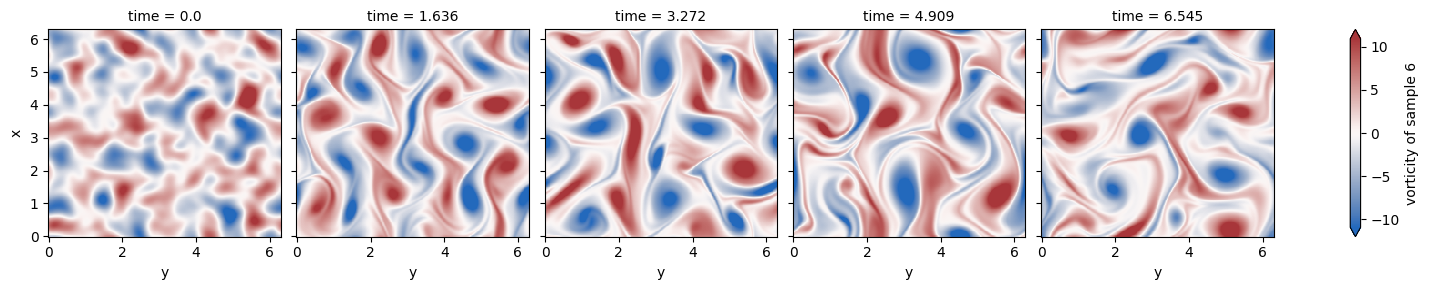

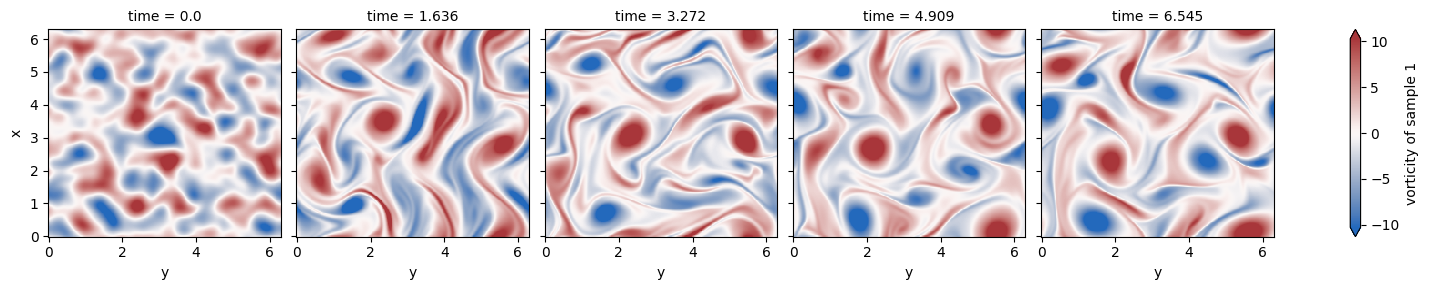

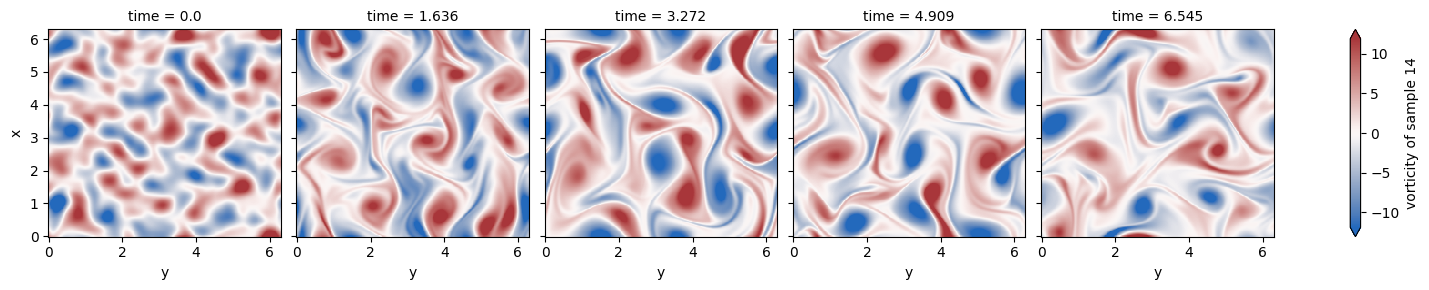

In [5]:
import seaborn as sns
import xarray
import numpy as np
import matplotlib.pyplot as plt

idxes = np.random.choice(np.arange(batch_size), size=3, replace=False)

trajectory_plot = np.stack(trajectory).astype(np.float64)

for idx in idxes:
    coords={
            "time": dt * inner_steps * np.arange(outer_steps),
            "x": np.linspace(0, 2 * np.pi, n),
            "y": np.linspace(0, 2 * np.pi, n),
        }
    ds = xarray.Dataset(
        {
            "u": (("time", "x", "y"), trajectory_plot[0, 1:, idx, ...]),
            "v": (("time", "x", "y"), trajectory_plot[1, 1:, idx, ...]),
        },
        coords=coords,
    )


    def vorticity(ds):
        return (ds.v.differentiate("x") - ds.u.differentiate("y")).rename(f"vorticity of sample {idx}")

    (
        ds.pipe(vorticity)
        .thin(time=20)
        .plot.imshow(col="time", cmap=sns.cm.vlag, robust=True, col_wrap=5)
    );